## Portfolio Trading

In [2]:
## install finrl library
!pip install swig
!pip install box2d
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.9/427.9 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d: filename=Box2D-2.3.2-cp310-cp310-linux_x86_64.whl size=2391309 sha256=ee9ce9c7fde953f08d8b385415faacf2d80965cd1d41cb92919f15e19c8b5dce
  Stored in directory: /root/.cache/pip/wheels/eb/cb/be/e663f3ce9aba6580611c0febaf7cd3cf7603f87047de2a52f9
Successfully built box2d
  Cloning https://github.com/AI4Finance-Foundation/FinRL.git to /tmp/pip-req-build-l4vrs24n
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/FinRL.git /tmp/pip-req-build-l4vrs24n
  Resolved https://github.com/AI4Finance-Foundation/FinRL.git to commit 1410c340ded1a2fb49b16caf972e55b3d1d6efbb
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/AI

In [3]:
import os
import itertools
import sys

import pandas as pd
import numpy as np
import datetime
import yfinance as yf
import matplotlib.pyplot as plt
%matplotlib inline

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.config import INDICATORS
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3.common.logger import configure
from finrl import config_tickers
from finrl.main import check_and_make_directories
from finrl.config import INDICATORS, TRAINED_MODEL_DIR, RESULTS_DIR
from stable_baselines3 import A2C, DDPG, PPO, SAC, TD3
from finrl.config import INDICATORS

check_and_make_directories([TRAINED_MODEL_DIR])

/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/dtypes.py:35: DeprecationWarning: ml_dtypes.float8_e4m3b11 is deprecated. Use ml_dtypes.float8_e4m3b11fnuz
  from tensorflow.tsl.python.lib.core import pywrap_ml_dtypes


In [4]:
TRAIN_START_DATE = '2010-11-10'
TRAIN_END_DATE = '2022-11-10'
TRADE_START_DATE = '2022-11-10'
TRADE_END_DATE = '2023-11-10'

In [5]:
df_raw = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TRADE_END_DATE,
                     ticker_list = config_tickers.DOW_30_TICKER).fetch_data()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [6]:
config_tickers.DOW_30_TICKER

['AXP',
 'AMGN',
 'AAPL',
 'BA',
 'CAT',
 'CSCO',
 'CVX',
 'GS',
 'HD',
 'HON',
 'IBM',
 'INTC',
 'JNJ',
 'KO',
 'JPM',
 'MCD',
 'MMM',
 'MRK',
 'MSFT',
 'NKE',
 'PG',
 'TRV',
 'UNH',
 'CRM',
 'VZ',
 'V',
 'WBA',
 'WMT',
 'DIS',
 'DOW']

In [6]:
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_vix=True,
                     use_turbulence=True,
                     user_defined_feature = False)

processed = fe.preprocess_data(df_raw)

Successfully added technical indicators
[*********************100%%**********************]  1 of 1 completed
Shape of DataFrame:  (3271, 8)
Successfully added vix
Successfully added turbulence index


In [7]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

In [8]:
train = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(processed_full, TRADE_START_DATE,TRADE_END_DATE)
print(len(train))
print(len(trade))

87609
7250


In [9]:
train.to_csv('portfolio_train_data.csv')
trade.to_csv('portfolio_trade_data.csv')

### Train

#### Env

In [14]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 29, State Space: 291


In [18]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}


e_train_gym = StockTradingEnv(df = train, **env_kwargs)

In [19]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


#### AGENTS

In [21]:
agent = DRLAgent(env = env_train)

# Set the corresponding values to 'True' for the algorithms that you want to use
if_using_a2c = True
if_using_ddpg = True
if_using_ppo = True
if_using_sac = True

##### A2C

In [22]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

if if_using_a2c:
  # set up logger
  tmp_path = RESULTS_DIR + '/a2c'
  new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_a2c.set_logger(new_logger_a2c)

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device
Logging to results/a2c


In [ ]:
trained_a2c = agent.train_model(model=model_a2c,
                             tb_log_name='a2c',
                             total_timesteps=50000) if if_using_a2c else None

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


------------------------------------
| time/                 |          |
|    fps                | 74       |
|    iterations         | 100      |
|    time_elapsed       | 6        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -41.4    |
|    explained_variance | 0.256    |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -14.9    |
|    reward             | 1.204226 |
|    std                | 1.01     |
|    value_loss         | 0.705    |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 67       |
|    iterations         | 200      |
|    time_elapsed       | 14       |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -41.4    |
|    explained_variance | -0.0211  |
|    learning_rate      | 0.0007   |
|    n_updates          | 199      |
|

In [25]:
trained_a2c.save(TRAINED_MODEL_DIR + "/agent_a2c") if if_using_a2c else None

##### DDPG

In [26]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

if if_using_ddpg:
  # set up logger
  tmp_path = RESULTS_DIR + '/ddpg'
  new_logger_ddpg = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ddpg.set_logger(new_logger_ddpg)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cpu device
Logging to results/ddpg


In [27]:
trained_ddpg = agent.train_model(model=model_ddpg,
                             tb_log_name='ddpg',
                             total_timesteps=50000) if if_using_ddpg else None

day: 3020, episode: 20
begin_total_asset: 1000000.00
end_total_asset: 4633775.87
total_reward: 3633775.87
total_cost: 1158.11
total_trades: 42349
Sharpe: 0.776
-----------------------------------
| time/              |            |
|    episodes        | 4          |
|    fps             | 25         |
|    time_elapsed    | 477        |
|    total_timesteps | 12084      |
| train/             |            |
|    actor_loss      | 120        |
|    critic_loss     | 6.1e+03    |
|    learning_rate   | 0.001      |
|    n_updates       | 9063       |
|    reward          | -12.602177 |
-----------------------------------
-----------------------------------
| time/              |            |
|    episodes        | 8          |
|    fps             | 22         |
|    time_elapsed    | 1078       |
|    total_timesteps | 24168      |
| train/             |            |
|    actor_loss      | 38.8       |
|    critic_loss     | 32.1       |
|    learning_rate   | 0.001      |
|    n_updat

In [28]:
trained_ddpg.save(TRAINED_MODEL_DIR + "/agent_ddpg") if if_using_ddpg else None

##### PPO

In [29]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

if if_using_ppo:
  # set up logger
  tmp_path = RESULTS_DIR + '/ppo'
  new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ppo.set_logger(new_logger_ppo)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cpu device
Logging to results/ppo


In [31]:
trained_ppo = agent.train_model(model=model_ppo,
                             tb_log_name='ppo',
                             total_timesteps=200000) if if_using_ppo else None

------------------------------------
| time/              |             |
|    fps             | 75          |
|    iterations      | 1           |
|    time_elapsed    | 27          |
|    total_timesteps | 2048        |
| train/             |             |
|    reward          | -0.40001985 |
------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 72          |
|    iterations           | 2           |
|    time_elapsed         | 56          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.015434484 |
|    clip_fraction        | 0.226       |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.1       |
|    explained_variance   | -0.00302    |
|    learning_rate        | 0.00025     |
|    loss                 | 4.72        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0264  

In [32]:
trained_ppo.save(TRAINED_MODEL_DIR + "/agent_ppo") if if_using_ppo else None

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Trade

In [10]:
if_using_a2c = True
if_using_ddpg = True
if_using_ppo = True

In [11]:
trained_a2c = A2C.load("/content/drive/MyDrive/RL_trading/trained_models_portfolio/"+ "/agent_a2c") if if_using_a2c else None
trained_ddpg = DDPG.load("/content/drive/MyDrive/RL_trading/trained_models_portfolio/" + "/agent_ddpg") if if_using_ddpg else None
trained_ppo = PPO.load("/content/drive/MyDrive/RL_trading/trained_models_portfolio/" + "/agent_ppo") if if_using_ppo else None

In [12]:
stock_dimension = len(trade.tic.unique())
state_space = 1 + 2 * stock_dimension + len(INDICATORS) * stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 29, State Space: 291


In [13]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}


In [14]:
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)

In [15]:
df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
    model=trained_a2c,
    environment = e_trade_gym) if if_using_a2c else (None, None)

hit end!


In [16]:
df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(
    model=trained_ddpg,
    environment = e_trade_gym) if if_using_ddpg else (None, None)

hit end!


In [17]:
df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
    model=trained_ppo,
    environment = e_trade_gym) if if_using_ppo else (None, None)

hit end!


In [23]:
TRADE_START_DATE = '2022-11-10'
TRADE_END_DATE = '2023-11-10'
df_dji = YahooDownloader(start_date = TRADE_START_DATE,
                     end_date = TRADE_END_DATE,
                     ticker_list = ['^DJI']).fetch_data()

[*********************100%%**********************]  1 of 1 completed
Shape of DataFrame:  (251, 8)


In [24]:
df_dji = df_dji[["date", "close"]]
fst_day = df_dji["close"][0]
dji = pd.merge(
    df_dji["date"],
    df_dji["close"].div(fst_day).mul(1000000),
    how="outer",
    left_index=True,
    right_index=True,
).set_index("date")

In [20]:
df_result_a2c = (
    df_account_value_a2c.set_index(df_account_value_a2c.columns[0])
    if if_using_a2c
    else None
)
df_result_ddpg = (
    df_account_value_ddpg.set_index(df_account_value_ddpg.columns[0])
    if if_using_ddpg
    else None
)
df_result_ppo = (
    df_account_value_ppo.set_index(df_account_value_ppo.columns[0])
    if if_using_ppo
    else None
)

In [25]:
result = pd.DataFrame(
    {
        "a2c": df_result_a2c["account_value"] if if_using_a2c else None,
        "ddpg": df_result_ddpg["account_value"] if if_using_ddpg else None,
        "ppo": df_result_ppo["account_value"] if if_using_ppo else None,
        "dji": dji["close"],
    }
)

In [35]:
result

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,a2c,ddpg,ppo,dji
date,,,,
2022-11-10,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06
2022-11-11,1.001344e+06,9.995044e+05,1.000256e+06,1.000964e+06
2022-11-14,9.988160e+05,9.961024e+05,9.994585e+05,9.947006e+05
2022-11-15,1.003366e+06,9.922170e+05,9.988715e+05,9.963681e+05
2022-11-16,9.993028e+05,9.953349e+05,9.986073e+05,9.952086e+05
...,...,...,...,...
2023-11-03,1.070469e+06,1.068204e+06,1.158632e+06,1.010261e+06
2023-11-06,1.073432e+06,1.073866e+06,1.164511e+06,1.011285e+06
2023-11-07,1.076622e+06,1.079457e+06,1.167808e+06,1.012968e+06


In [36]:
result.columns = ['A2C', 'DDPG', 'PPO', 'DJI']

<Figure size 1500x500 with 0 Axes>

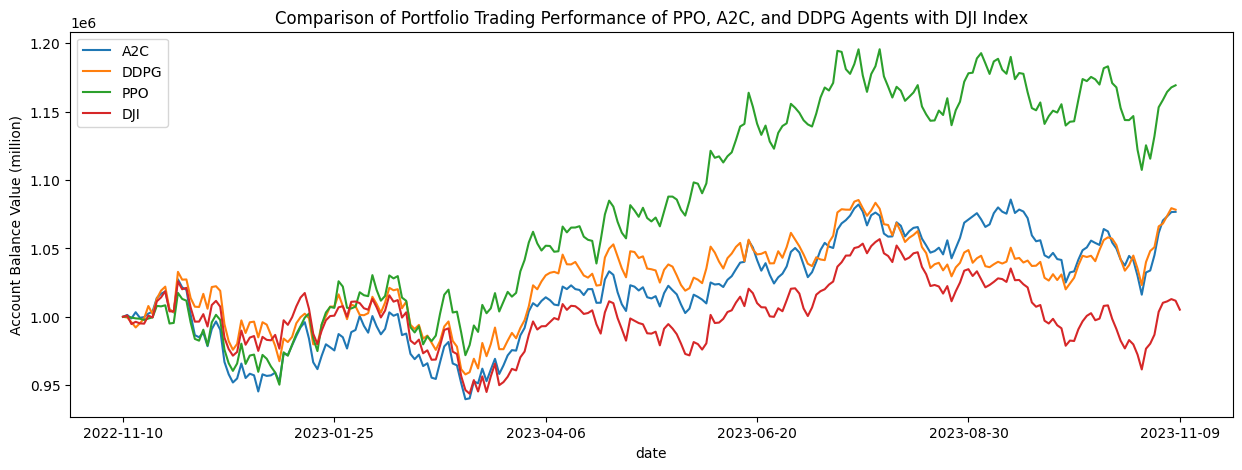

In [37]:
plt.rcParams["figure.figsize"] = (15, 5)
plt.figure()
result.plot()
plt.title('Comparison of Portfolio Trading Performance of PPO, A2C, and DDPG Agents with DJI Index')
plt.ylabel('Account Balance Value (million)')
plt.show()

#### Mean Variance Optimization

In [39]:
def process_df_for_mvo(df):
  return df.pivot(index="date", columns="tic", values="close")

def StockReturnsComputing(StockPrice, Rows, Columns):
  import numpy as np
  StockReturn = np.zeros([Rows-1, Columns])
  for j in range(Columns):        # j: Assets
    for i in range(Rows-1):     # i: Daily Prices
      StockReturn[i,j]=((StockPrice[i+1, j]-StockPrice[i,j])/StockPrice[i,j])* 100

  return StockReturn

In [40]:
StockData = process_df_for_mvo(train)
TradeData = process_df_for_mvo(trade)

TradeData.to_numpy()

array([[146.05361938, 279.33755493, 152.49461365, ...,  35.88434601,
         35.48928833, 140.21343994],
       [148.86790466, 273.58776855, 152.63259888, ...,  35.67939758,
         38.04333496, 140.43013   ],
       [147.45578003, 273.85653687, 151.88365173, ...,  35.68871689,
         37.81943893, 136.30331421],
       ...,
       [178.9941864 , 270.70153809, 152.99000549, ...,  35.63999939,
         21.26664925, 164.88000488],
       [181.58078003, 268.9949646 , 152.97999573, ...,  35.93999863,
         21.14942169, 165.6499939 ],
       [182.64936829, 271.12820435, 153.00999451, ...,  35.77000046,
         20.51445198, 164.30000305]])

In [54]:
arStockPrices = np.asarray(StockData)
[Rows, Cols]=arStockPrices.shape
# return percentage of each stock each day
arReturns = StockReturnsComputing(arStockPrices, Rows, Cols)
meanReturns = np.mean(arReturns, axis = 0)
covReturns = np.cov(arReturns, rowvar=False)
#set precision for printing results
np.set_printoptions(precision=3, suppress = True)
#display mean returns and variance-covariance matrix of returns betweeen stocks
#print('Mean returns of assets in k-portfolio 1\n', meanReturns)
#print('Variance-Covariance matrix of returns\n', covReturns)

In [59]:
from pypfopt.efficient_frontier import EfficientFrontier

ef_mean = EfficientFrontier(meanReturns, covReturns, weight_bounds=(0, 0.5))
raw_weights_mean = ef_mean.max_sharpe()
cleaned_weights_mean = ef_mean.clean_weights()
mvo_weights = np.array([1000000 * cleaned_weights_mean[i] for i in range(len(cleaned_weights_mean))])

LastPrice = np.array([1/p for p in StockData.tail(1).to_numpy()[0]])
Initial_Portfolio = np.multiply(mvo_weights, LastPrice)

Portfolio_Assets = TradeData @ Initial_Portfolio
MVO_result = pd.DataFrame(Portfolio_Assets, columns=["Mean Var"])
MVO_result

,Mean Var
date,
2022-11-10,1.049936e+06
2022-11-11,1.040339e+06
2022-11-14,1.025572e+06
2022-11-15,1.026194e+06
2022-11-16,1.033550e+06
...,...
2023-11-02,1.115843e+06
2023-11-03,1.112817e+06
2023-11-06,1.118307e+06


In [60]:
result2 = pd.DataFrame(
    {
        "a2c": df_result_a2c["account_value"] if if_using_a2c else None,
        "ddpg": df_result_ddpg["account_value"] if if_using_ddpg else None,
        "ppo": df_result_ppo["account_value"] if if_using_ppo else None,
        "mvo": MVO_result["Mean Var"],
        "dji": dji["close"],
    }
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Figure size 2500x1000 with 0 Axes>

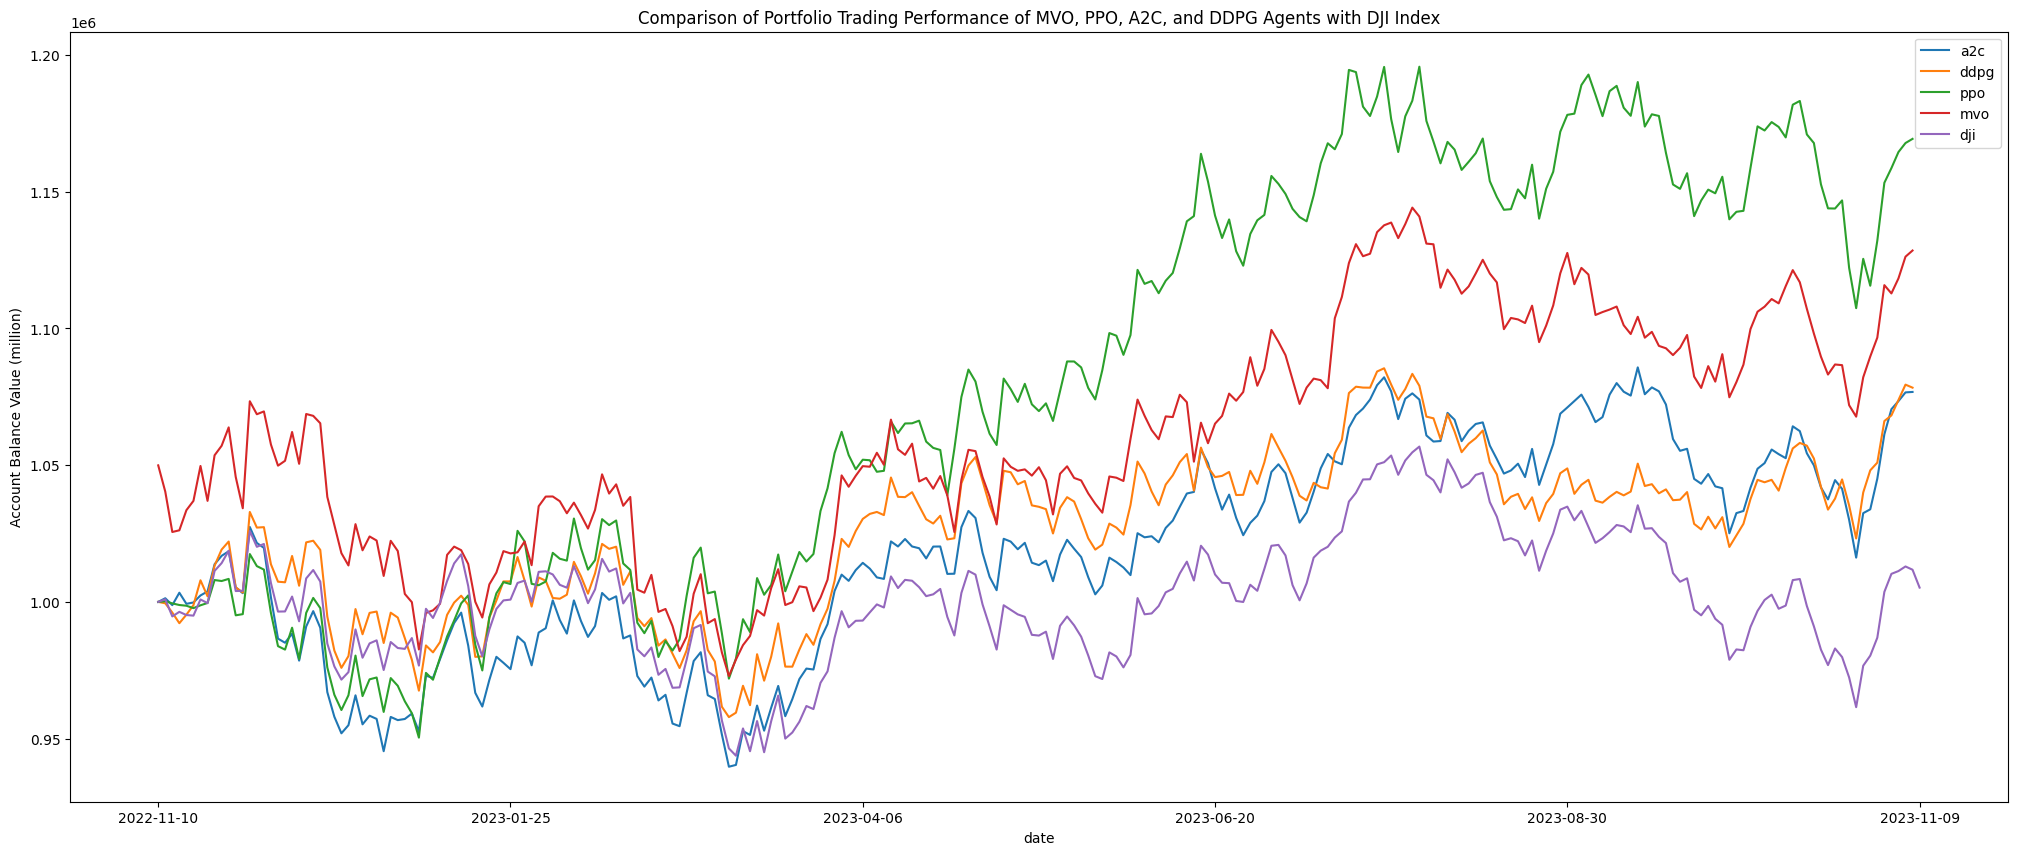

In [63]:
plt.rcParams["figure.figsize"] = (25, 10)
plt.figure()
result2.plot()
plt.title('Comparison of Portfolio Trading Performance of MVO, PPO, A2C, and DDPG Agents with DJI Index')
plt.ylabel('Account Balance Value (million)')
plt.show()